16×1 Matrix{ComplexF64}:
 -0.23115764173357073 + 0.09064713199940932im
  0.36570317159990195 - 0.07093122512344674im
 -0.02081863932149991 + 0.16792686603475415im
    0.063644005207325 - 0.3368299612515709im
  -0.1252426594668838 + 0.08062256357515701im
 -0.07798595745066839 - 0.2840959639264683im
 -0.06875297222985755 + 0.2822421169819086im
 -0.12922885168486947 - 0.0983444950796723im
  0.13978724726806693 + 0.22373653965077472im
  -0.0599598289699466 - 0.042757719279926776im
  0.34105543821197926 - 0.056067105466805045im
 -0.16173816824613768 - 0.014793028997988733im
  0.11304999818376138 - 0.23304678502738307im
 -0.17896954142194366 + 0.13030082563307827im
 -0.17370907038215438 - 0.13027616252393082im
   0.1103124218285968 + 0.21352939793250214im

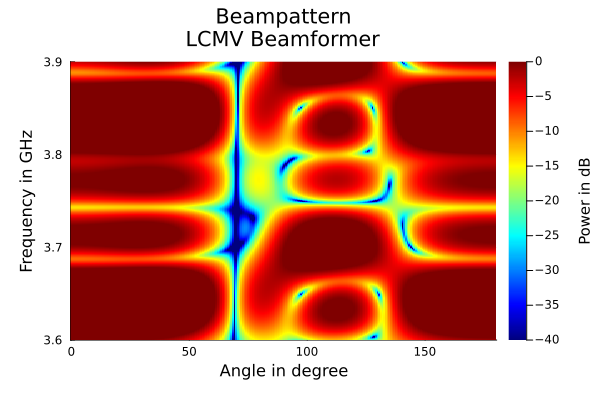

In [5]:
using ArraySignalProcessing
pa = TappedDelayLine(IsotropicArrayManifold(-6e-2, -2e-2, 2e-2, 6e-2), 4, 200e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-1, 3.75e9) + whitenoise(pa, 1e-2)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, deg2rad.([30 70]), [3.76e9, 3.7e9, 3.8e9, 3.9e9])

# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(Snn, C, G)
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
A = steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis)
W = reduce(vcat, Ref(weights') .* A)
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, WdB, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)

16×1 CuArray{ComplexF64, 2, CUDA.DeviceMemory}:
  -0.2311577509133306 + 0.0906468473881387im
  0.36570313897321094 - 0.0709311776038206im
 -0.02081863944375621 + 0.1679268723873619im
  0.06364385901759834 - 0.33683010531178836im
 -0.12524267003082565 + 0.08062249856250035im
 -0.07798607192382785 - 0.28409606379823177im
 -0.06875292011915812 + 0.28224222731649573im
 -0.12922879453863928 - 0.09834455609585285im
   0.1397871618182035 + 0.2237366409899746im
 -0.05995991941272637 - 0.04275768878246523im
   0.3410554835325871 - 0.05606712881004236im
 -0.16173823058000003 - 0.014792990100486486im
  0.11305028942230949 - 0.23304685681566303im
  -0.1789695682320317 + 0.1303008154649172im
  -0.1737090955083396 - 0.1302761017921401im
  0.11031263146284853 + 0.2135293073148372im

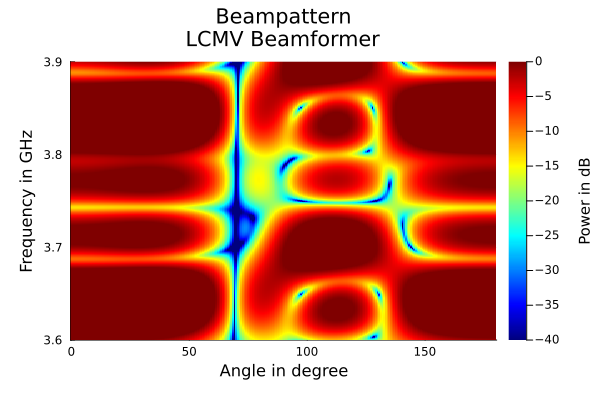

In [7]:
using ArraySignalProcessing
using CUDA
pa = TappedDelayLine(IsotropicArrayManifold(cu([-6e-2, -2e-2, 2e-2, 6e-2])), 4, 200e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-1, 3.75e9) + whitenoise(pa, 1e-2)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, cu(deg2rad.([30 70])), [3.76e9, 3.7e9, 3.8e9, 3.9e9])
# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(cu(Snn), C, cu(G))
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
#A = steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis)
#W = reduce(vcat, Ref(weights') .* A)
A = steer(pa, cu(deg2rad.(ϕaxis)), faxis)
W = transpose(reshape(weights' * A, :, length(faxis)))
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, Array(WdB), cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)